In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [4]:
dе = pd.read_excel("D:\data.xlsx")
print(dе.shape)
dе.head()

(25, 5)


,y,x1,x2,x3,x4
0,0.904,75.5,25.2,3343,77.0
1,0.922,78.5,21.8,3001,78.2
2,0.763,78.4,25.7,3101,68.0
3,0.923,77.7,17.8,3543,77.2
4,0.918,84.4,15.9,3237,77.2


#### Таргентное и признаковое пространства

In [5]:
target_y = 'y'
x = data.loc[:, data.columns != target_y]
y = data.loc[:, target_y]

#### Тестовая - 20% и обучающая выборка - 80%

In [6]:
x_train_, x_test, y_train_, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_train_m, y_train, y_train_m = train_test_split(x_train_, y_train_, test_size = 0.4, random_state = 42)

In [8]:
x_trains = pd.DataFrame()
a_trains = pd.DataFrame()
tr_se = {}

#### Создадим функцию, которая находит все аргументы для поколения

In [9]:
def comb_f(x) -> set:
    comb = set()
    columns = x.columns
    for f in range(len(columns)):
        for s in range(f, len(columns)):
            if columns[f] != columns[s]:
                comb.add((columns[f], columns[s]))
    return comb

#### Среднеквадротическая ошибка

In [10]:
def mse(y_test, y_pr):
    return np.square(y_test - y_pr).mean()

#### Средняя ошибка аппроксимации

In [11]:
def mea(y_test, y_pr):
    n = len(y_test)
    return (1/n)*sum((abs(y_test - y_pr) / y_test) * 100)

#### Метод наименьших квадратов

In [12]:
def mls(x, y):
    x = sm.add_constant(x)
    a = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)), x.T), y)
    return a

#### Построение прогноза

In [13]:
def pred(a, x):
    return np.dot(x, a.T)

#### Создадим функцию, которая расчитывает следующие поколения

In [14]:
def gen(comb, x):
    for c in comb:
        x1, x2 = c
        X_train = sm.add_constant(x[[x1, x2]])
        a = mls(X_train, y_train)
        X_train_m = sm.add_constant(x_train_m[[x1, x2]])
        se = mse(y_train_m, pred(a, X_train_m))
        if len(x1) <= 2:
            x_trains[x1 + x2] = pred(a, X_train)
            x_train_m[x1 + x2] = pred(a, X_train_m)
            a_trains[x1 + x2] = a
            trains_se[x1 + x2] = se
        else:
            if se < trains_se[min(trains_se, key = trains_se.get)]:
                x_trains[x1 + x2] = pred(a, X_train)
                x_train_m[x1 + x2] = pred(a, X_train_m)
                a_trains[x1 + x2] = a
                trains_se[x1 + x2] = se

#### Обучение

In [15]:
comb = comb_f(x_train)
gen(comb, x_train)

for mp in range(1, len(comb)):
    new_c = [col for col in x_trains.columns if len(col) == mp*4]
    new_comb = comb_f(x_trains[new_c])
    gen(new_comb, x_trains)

#### Создадим функцию, которая возвращает список поколений

In [16]:
res_a = []
def rec(s: str):
    res_a.append(s)
    cen = len(s)//2
    if len(s[:cen]) != 4:
        rec(s[:cen])
        rec(s[cen:])
    else:
        res_a.append(s[:cen])
        res_a.append(s[cen:])

In [17]:
rec(min(trains_se, key = trains_se.get))
res_a

['x1x2x1x4', 'x1x2', 'x1x4']

#### Первое поколение

In [18]:
y1 = np.dot(sm.add_constant(x_test[['x1', 'x4']]), a_trains['x1x4'])
y2 = np.dot(sm.add_constant(x_test[['x1', 'x2']]), a_trains['x1x2'])

#### Второе покление

In [19]:
z = np.dot(sm.add_constant(pd.DataFrame({'y1':y1, 'y2':y2})), a_trains['x1x2x1x4'])

#### Среденеквадратичная ошибка

In [20]:
se = mse(y_test, z)
se

0.002209525413123463

#### Сравнение предсказанных значений с исходными значениями

In [21]:
for e, test in zip(z, y_test):
    print(f'y = {test} \ty_pred = {e} \tse = {(test-e)**2}')

y = 0.894 	y_pred = 0.8932007148947757 	se = 6.388566794334398e-07
y = 0.802 	y_pred = 0.8275771139942886 	se = 0.0006541887602768299
y = 0.904 	y_pred = 0.8682178678756711 	se = 0.0012803609793629305
y = 0.914 	y_pred = 0.9192395356417151 	se = 2.7452733740802733e-05
y = 0.74 	y_pred = 0.8353151915255764 	se = 0.009084985735557318


#### Представим график предсказанных и исходных значений

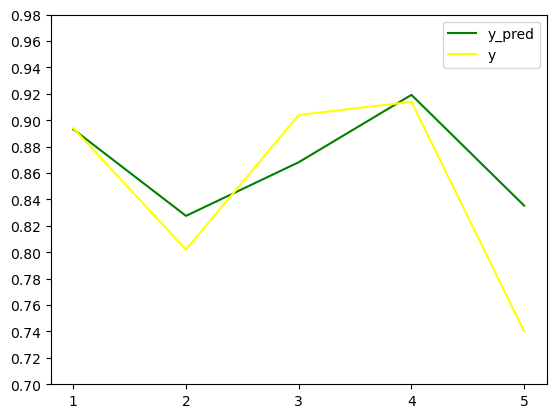

In [24]:
plt.plot([x for x in range(1, 6)], z, c='green', label='y_pred')
plt.plot([x for x in range(1, 6)], y_test, c='yellow', label='y')
plt.yticks([x/100 for x in range(70, 100, 2)])
plt.xticks([x for x in range(1, 6)])
plt.legend()

#### Средняя ошибка аппроксимации

In [23]:
mea(y_test, z)

4.1380913844326415

## Вывод

##### Средняя ошибка аппроксимации = 4.1380913844326415 (<10)
##### Среднеквадротичная ошибка = 0.002209525413123463